In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd 
import os
count=0
for dirname, _, filenames in os.walk('/content/drive/MyDrive/german traffic dataset'):
    for filename in filenames:
        count+=1
        #print(os.path.join(dirname, filename))
print('Total Images Loaded :',count)

Total Images Loaded : 51905


In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)

In [ ]:
data_dir = '/content/drive/MyDrive/german traffic dataset'
train_path = '/content/drive/MyDrive/german traffic dataset/Train'
test_path = '/content/drive/MyDrive/german traffic dataset/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

In [ ]:
NUM_CATEGORIES = len(os.listdir(train_path))
print('Total trainable classes: ',NUM_CATEGORIES)

Total trainable classes:  43


In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

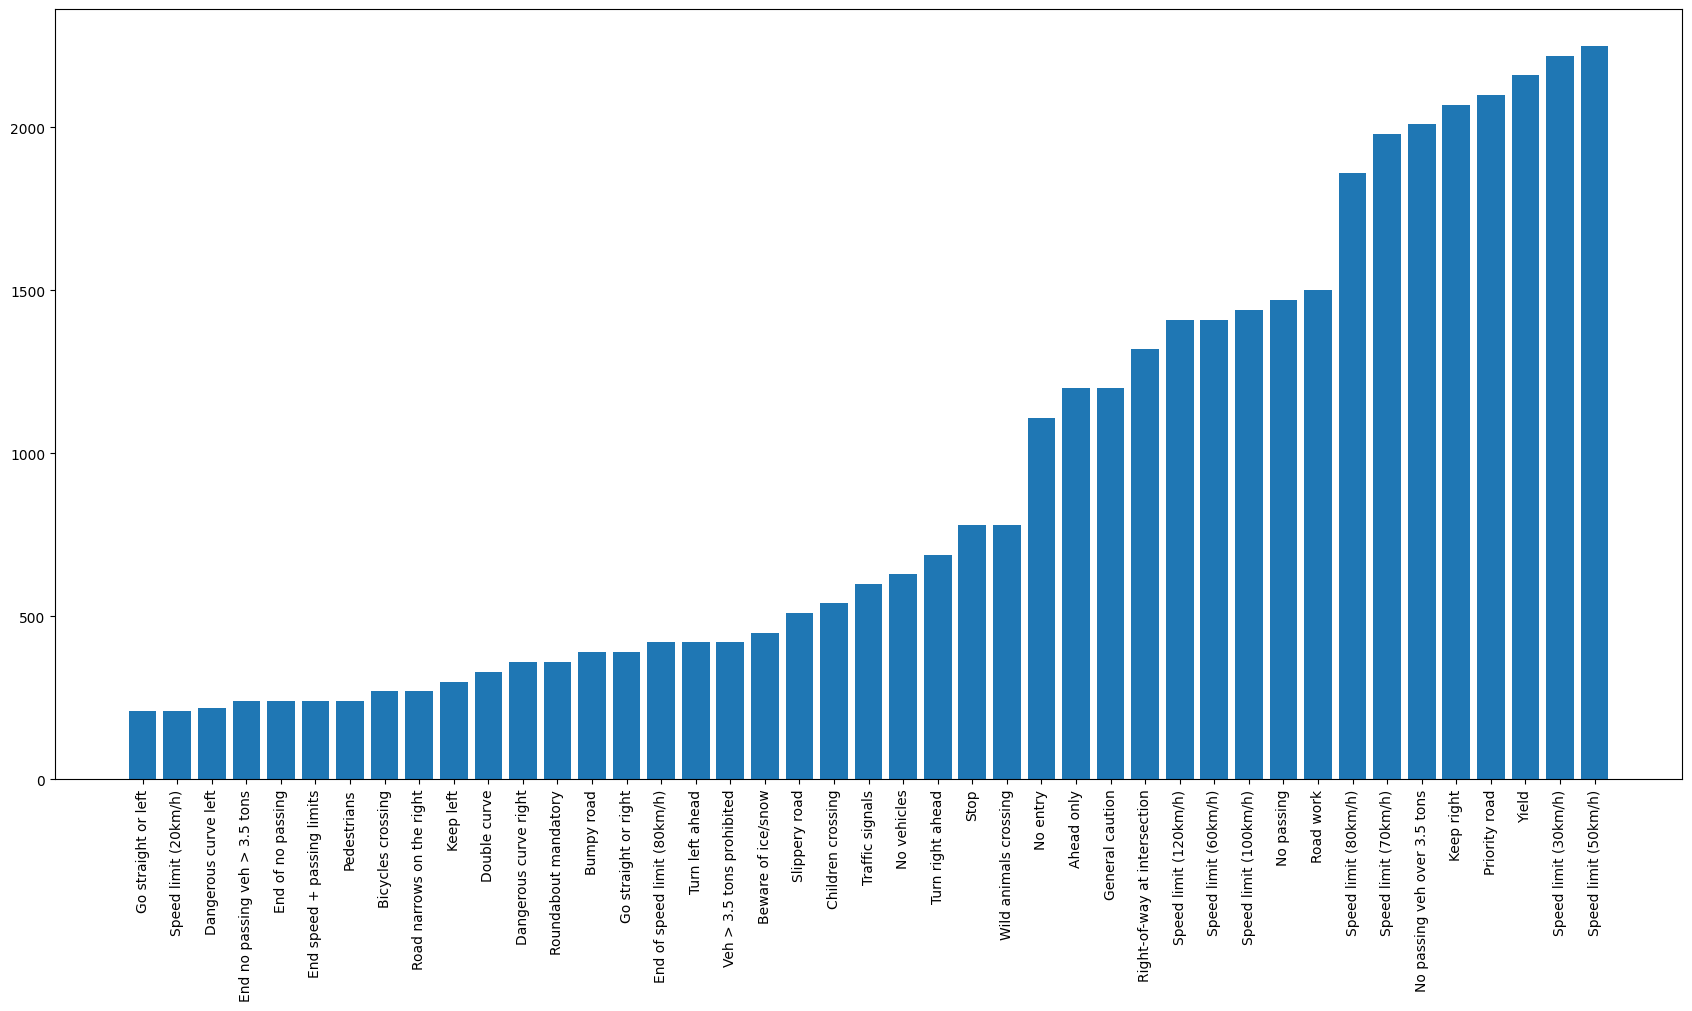

In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

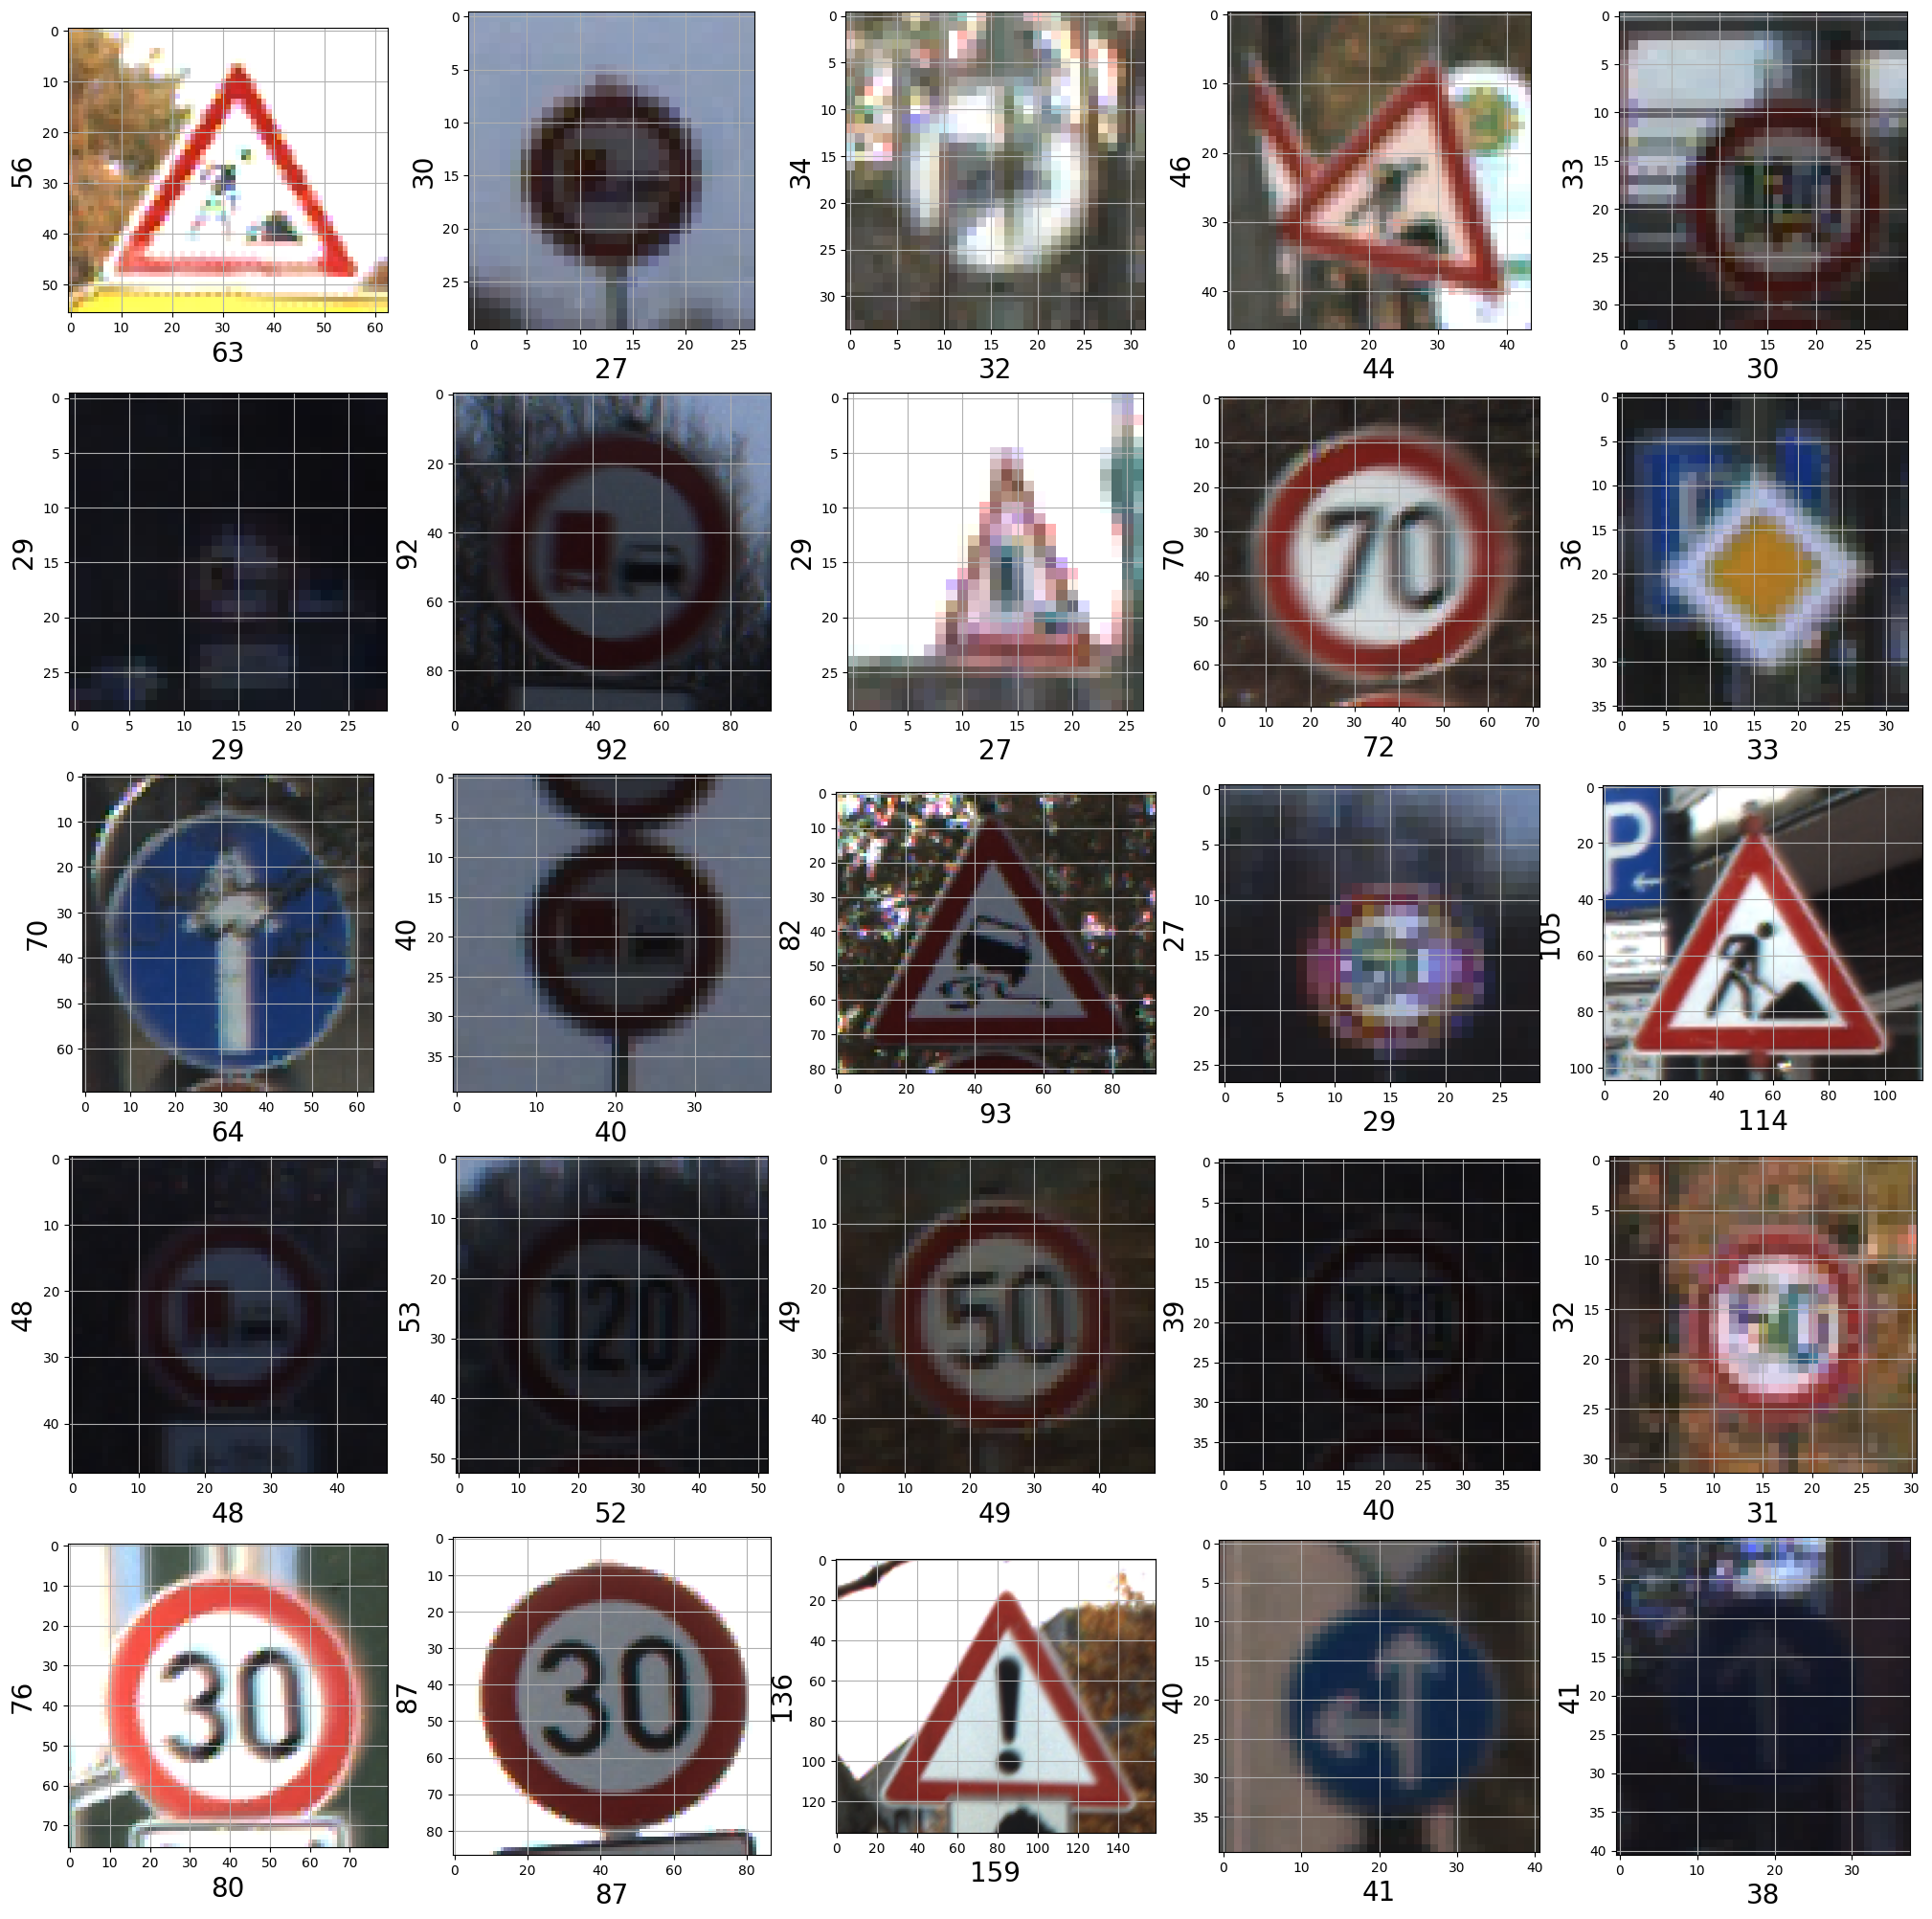

In [ ]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid()
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

In [ ]:
image_data = []
image_labels = []

for i in range(NUM_CATEGORIES):
    path = data_dir + '/Train/' + str(i)
    images = os.listdir(path)

    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)
        except:
            print("Error in " + img)
image_data = np.array(image_data)
image_labels = np.array(image_labels)

print(image_data.shape, image_labels.shape)

(39217, 30, 30, 3) (39217,)


In [ ]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27451, 30, 30, 3)
X_valid.shape (11766, 30, 30, 3)
y_train.shape (27451,)
y_valid.shape (11766,)


In [ ]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27451, 43)
(11766, 43)


In [ ]:
model = Sequential()   
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,channels)))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
epochs = 50
history = model.fit(X_train, y_train, batch_size=64, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/50
429/429 [==============================] - 15s 9ms/step - loss: 1.6193 - accuracy: 0.5594 - val_loss: 0.2263 - val_accuracy: 0.9397
Epoch 2/50
429/429 [==============================] - 4s 8ms/step - loss: 0.2969 - accuracy: 0.9120 - val_loss: 0.0833 - val_accuracy: 0.9777
Epoch 3/50
429/429 [==============================] - 3s 7ms/step - loss: 0.1654 - accuracy: 0.9498 - val_loss: 0.0658 - val_accuracy: 0.9812
Epoch 4/50
429/429 [==============================] - 3s 7ms/step - loss: 0.1177 - accuracy: 0.9667 - val_loss: 0.0351 - val_accuracy: 0.9908
Epoch 5/50
429/429 [==============================] - 3s 7ms/step - loss: 0.0985 - accuracy: 0.9706 - val_loss: 0.0330 - val_accuracy: 0.9911
Epoch 6/50
429/429 [==============================] - 3s 8ms/step - loss: 0.0799 - accuracy: 0.9764 - val_loss: 0.0298 - val_accuracy: 0.9927
Epoch 7/50
429/429 [==============================] - 3s 8ms/step - loss: 0.0681 - accuracy: 0.9795 - val_loss: 0.0237 - val_accuracy: 0.9933
Epoch

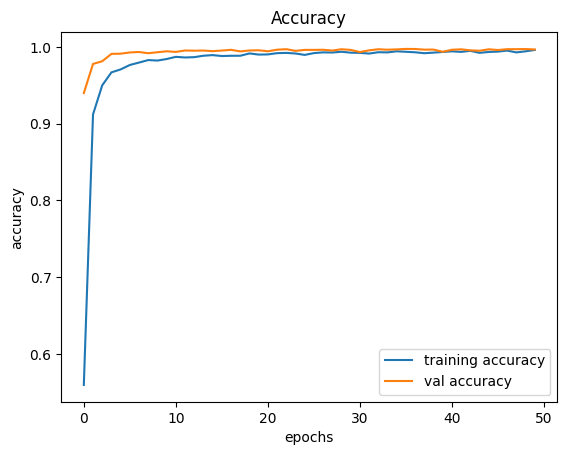

In [ ]:
#plotting graphs for accuracy 
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

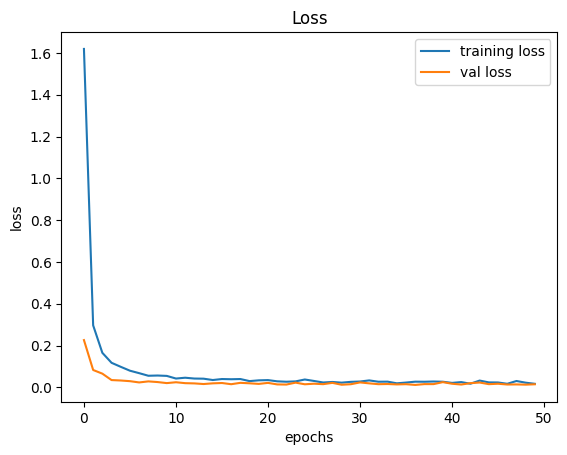

In [ ]:
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/german traffic dataset/saved_model/Traffic_sign_50_3.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from tensorflow import keras

model = keras.models.load_model('/content/drive/MyDrive/german traffic dataset/saved_model/Traffic_sign_50_3.h5')
test = pd.read_csv(data_dir + '/Test.csv')

labels = test["ClassId"].values
imgs = test["Path"].values

data =[]

for img in imgs:
    try:
        image = cv2.imread(data_dir + '/' +img)
        image_fromarray = Image.fromarray(image, 'RGB')
        resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
        data.append(np.array(resize_image))
    except:
        print("Error in " + img)
X_test = np.array(data)
X_test = X_test/255

#pred = model.predict_classes(X_test)
pred = model.predict(X_test) 
pred = np.argmax(pred, axis=1)
[print(i,' ',end='') for i in pred]

#Accuracy with the test data
print('\nTest Data accuracy: ',accuracy_score(labels, pred)*100)

395/395 [==============================] - 3s 2ms/step
16  1  38  33  11  38  18  12  25  35  12  7  23  7  4  9  21  20  27  38  4  33  9  3  1  11  13  10  9  11  5  17  34  23  2  17  3  12  16  8  7  30  18  12  24  25  3  10  31  8  1  13  15  9  13  35  5  26  9  16  38  10  4  9  15  9  26  2  5  28  11  25  30  34  5  12  1  10  25  25  21  33  25  7  10  35  3  7  22  13  3  1  2  14  12  32  3  38  9  33  1  10  5  11  33  4  35  25  33  4  1  14  16  10  30  3  27  23  1  17  13  7  1  8  2  10  10  30  1  6  36  3  14  13  11  10  18  40  2  38  41  4  6  18  17  25  2  41  11  21  7  24  11  25  17  3  6  9  7  4  13  16  4  19  18  9  13  14  29  17  13  38  26  25  33  1  5  40  13  2  8  4  36  25  20  25  18  1  10  8  10  29  12  38  31  2  8  38  21  28  17  9  4  1  17  9  2  31  13  15  15  38  25  5  25  13  10  5  4  10  2  4  5  1  14  12  12  5  8  36  25  13  33  18  33  19  12  30  4  18  12  13  20  0  10  40  5  3  12  38  20  14  0  36  34  28  35  13  25 

In [ ]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, pred)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.95      1.00      0.97       720
           2       0.98      0.99      0.99       750
           3       0.98      0.97      0.97       450
           4       1.00      0.98      0.99       660
           5       0.98      0.95      0.97       630
           6       0.99      0.98      0.99       150
           7       0.99      0.99      0.99       450
           8       0.96      0.98      0.97       450
           9       0.99      1.00      0.99       480
          10       1.00      0.97      0.98       660
          11       0.97      0.93      0.95       420
          12       1.00      0.99      0.99       690
          13       0.98      1.00      0.99       720
          14       1.00      1.00      1.00       270
          15       0.96      0.96      0.96       210
          16       0.97      0.99      0.98       150
          17       1.00    

<Axes: >

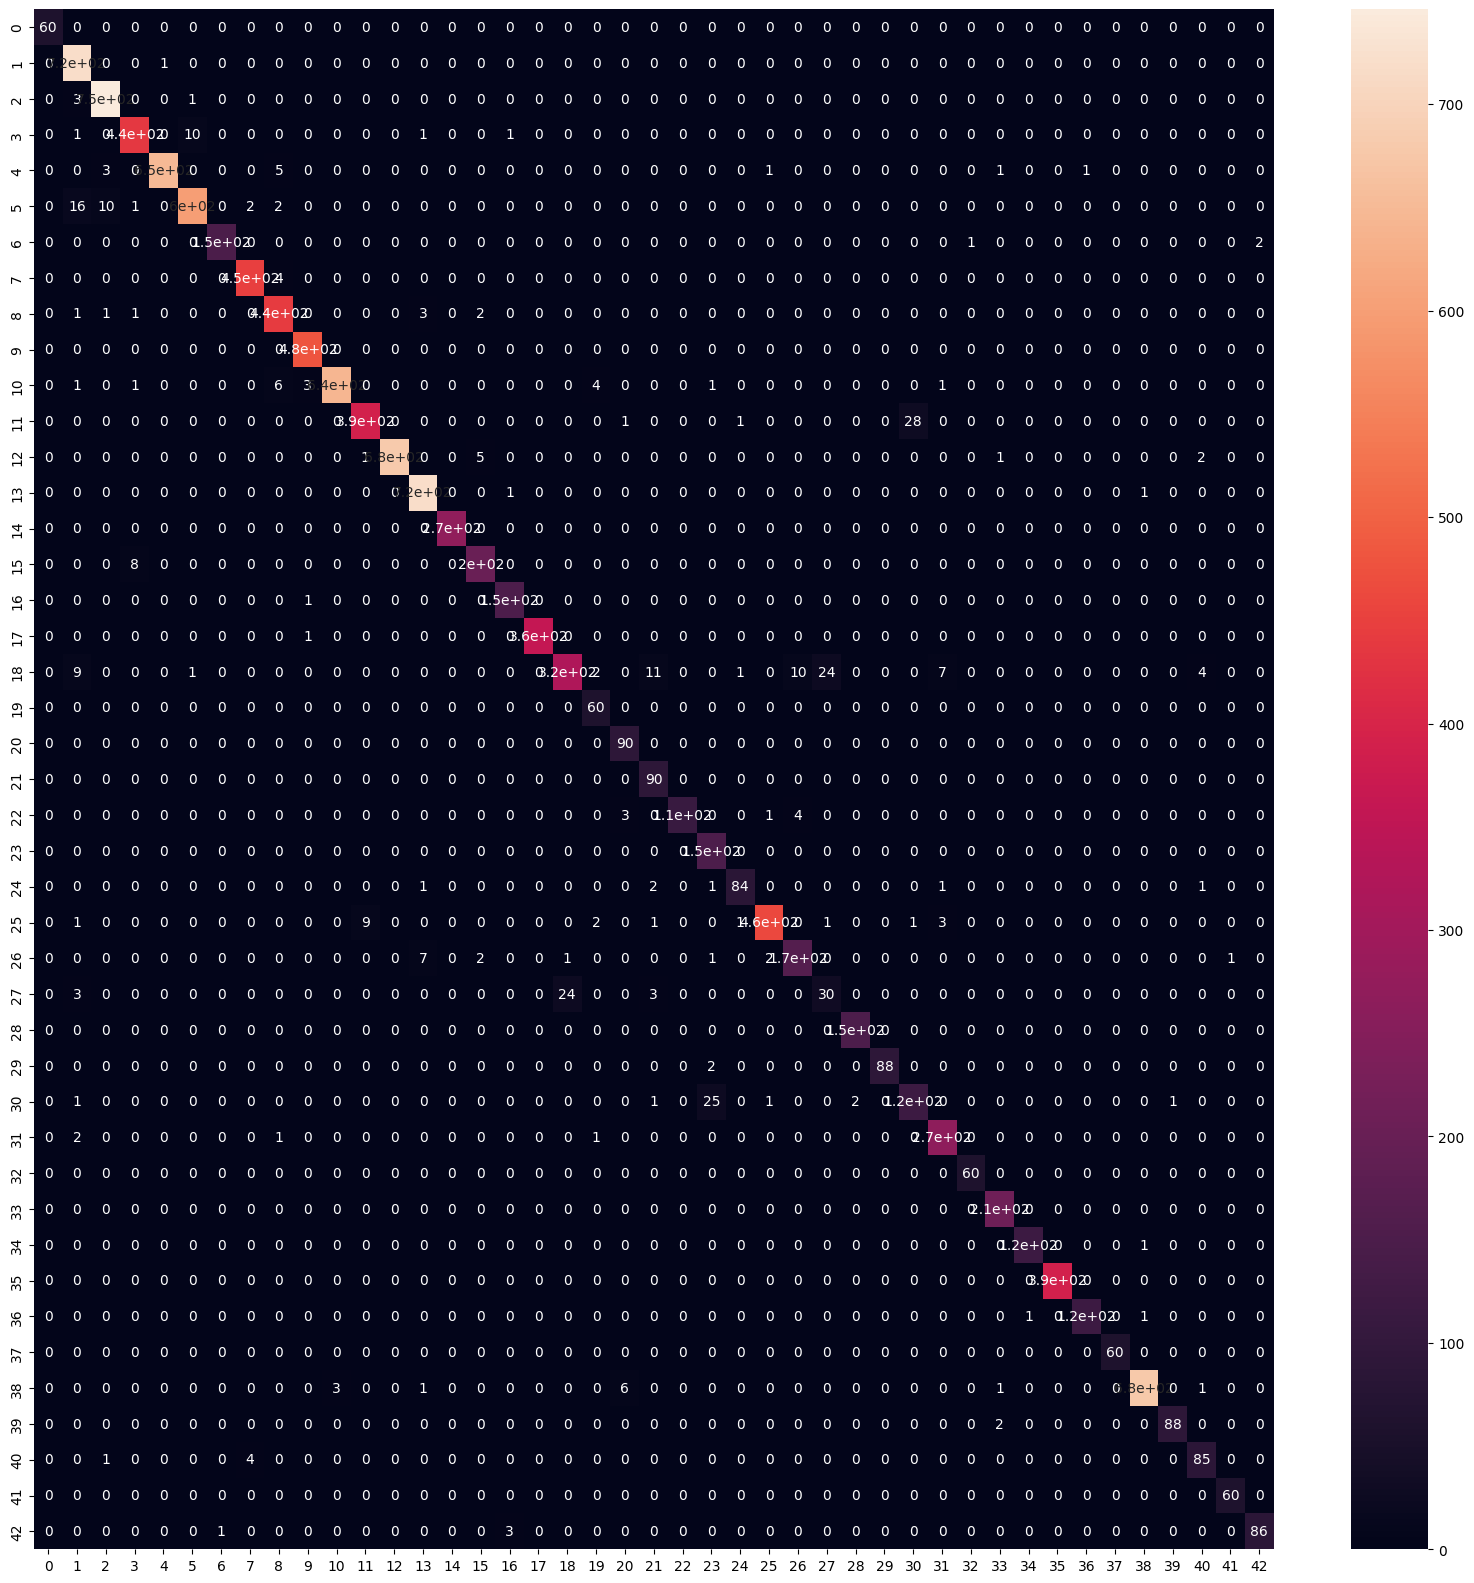

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

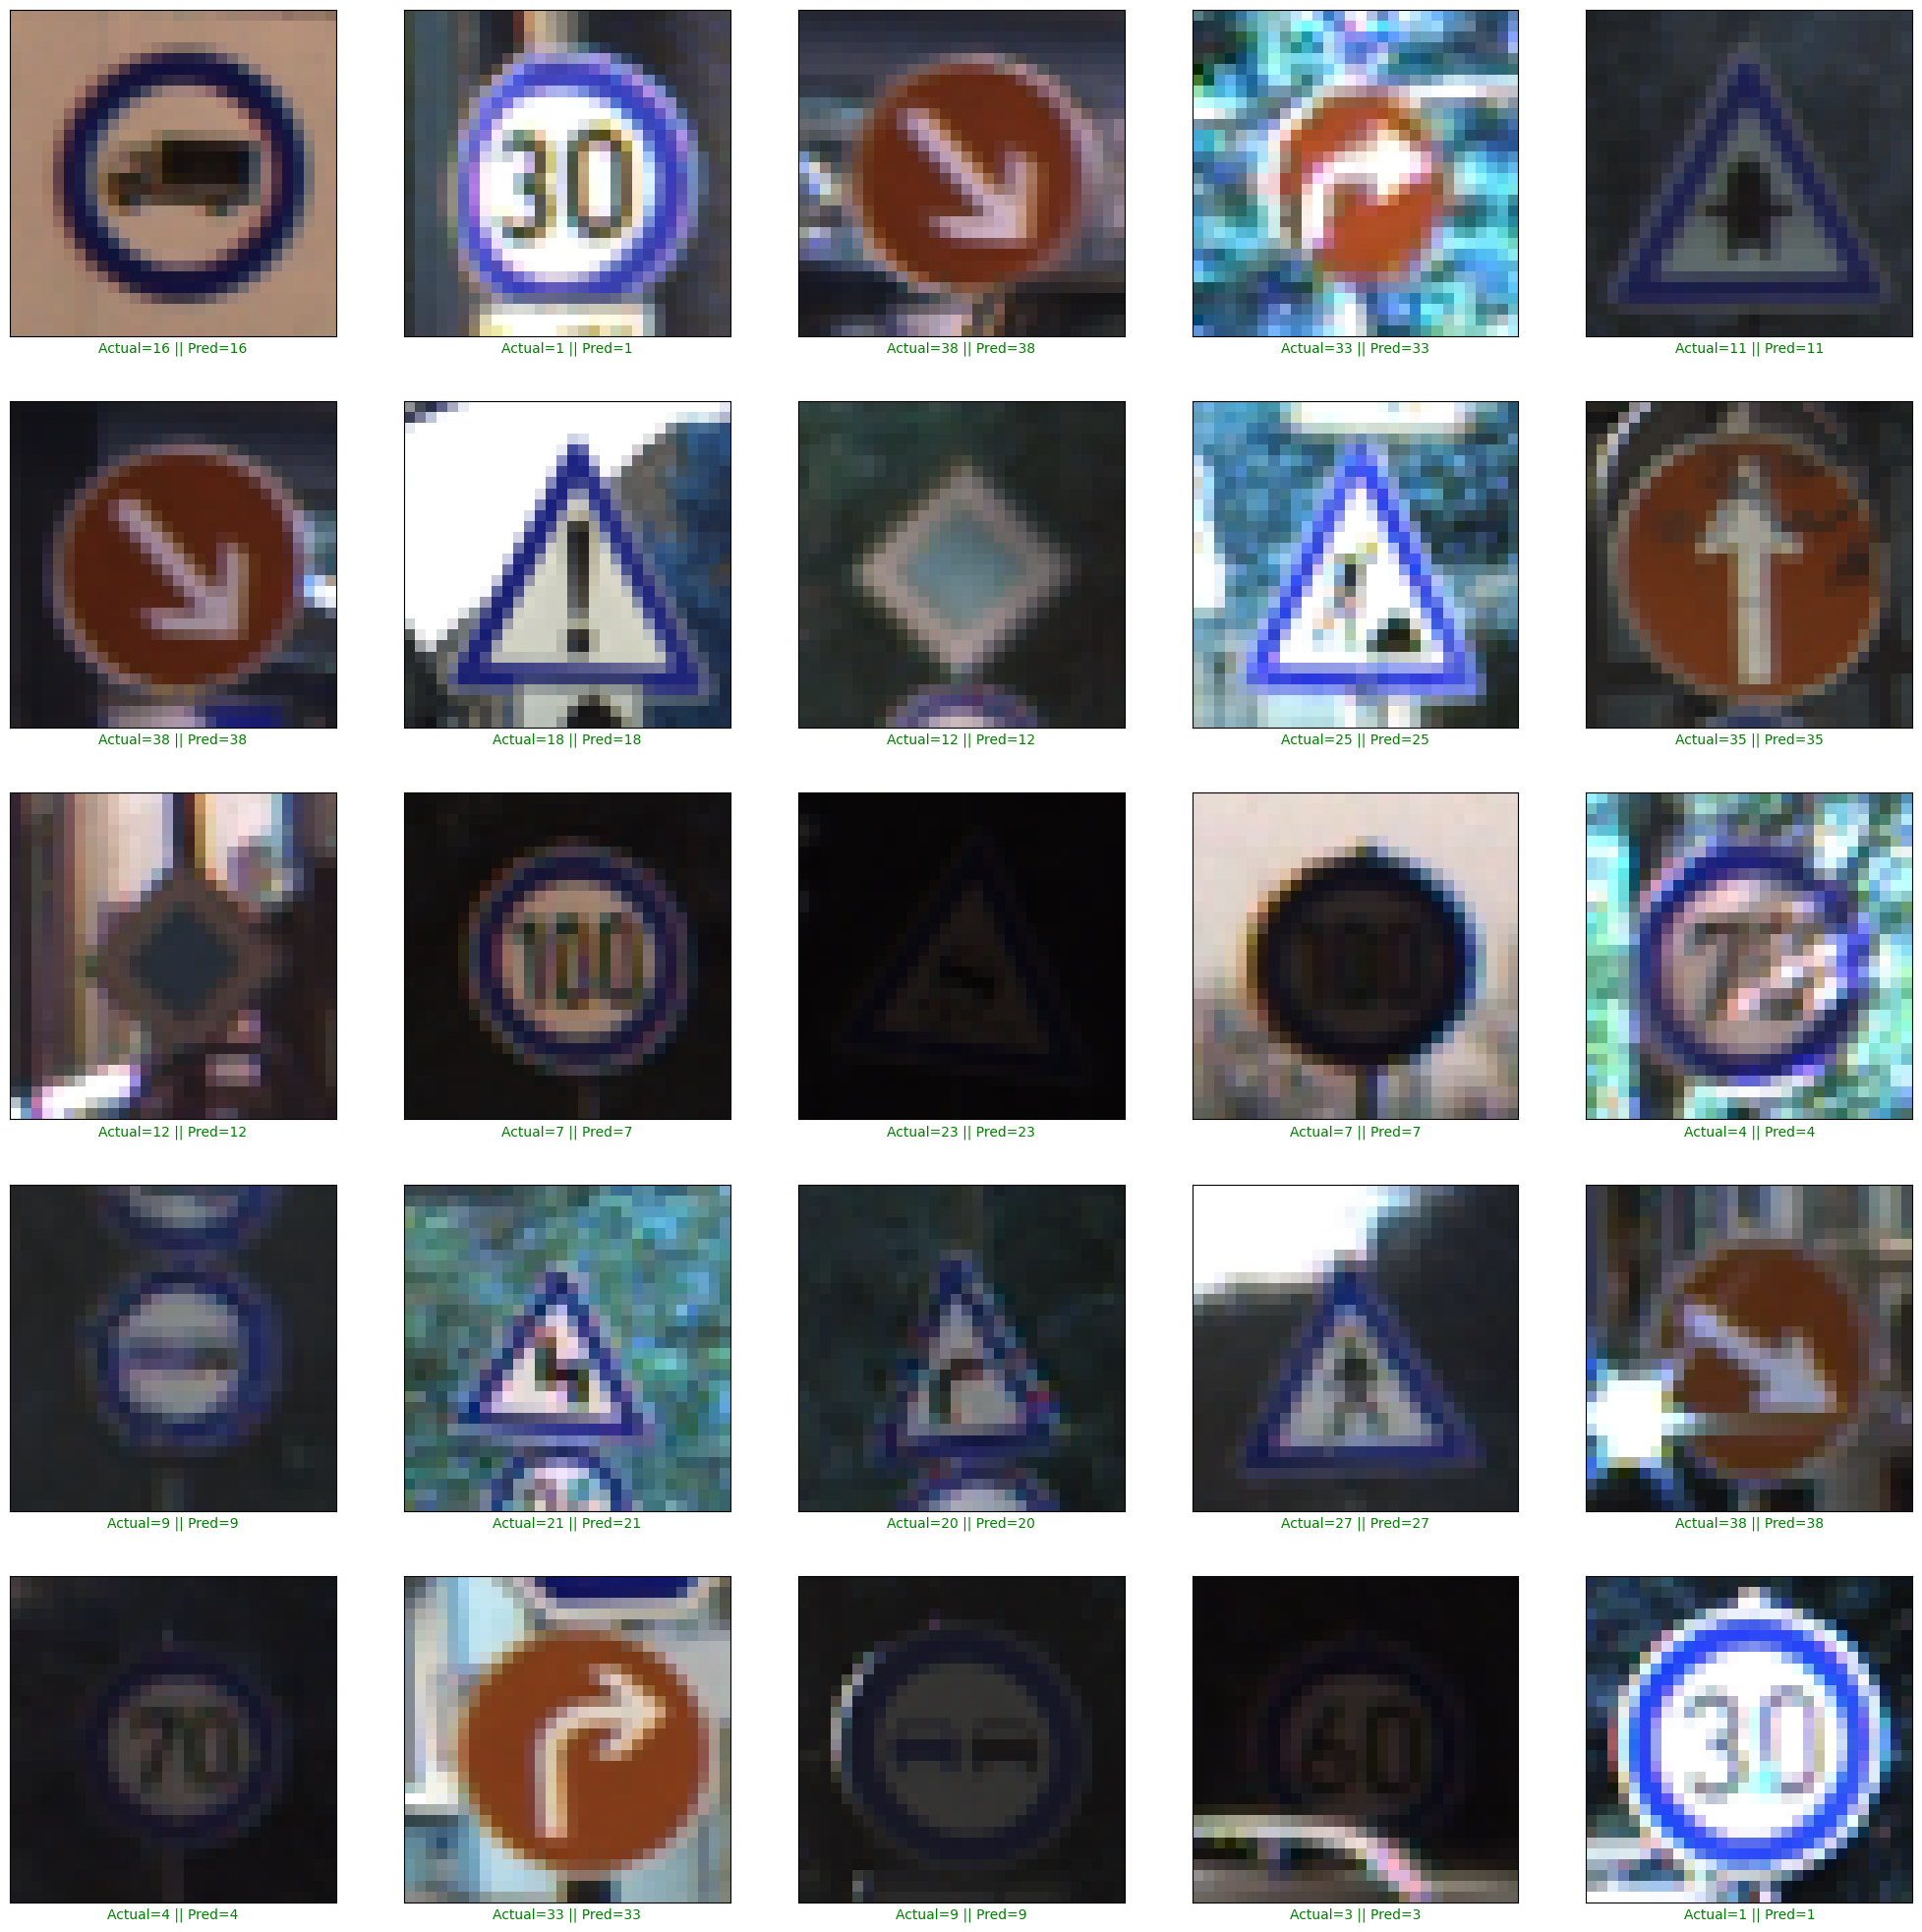

In [ ]:
plt.figure(figsize = (25, 25))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()